In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

c:\Users\Bryan Fernandez\Desktop\doc-classifier


C:\Users\Bryan Fernandez\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### 1. Importation des bibliothèques et configuration de la GPU

In [2]:
from src import save_jsonfile, read_jsonfile, create_train_dataset, plot_history
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
learning_rate = 0.0001
batch_size = 32

#### Vérification de la GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### 2. Chargement des bases de données

In [4]:
# Lire le fichier CSV
df_train = pd.read_csv('data/processed/DL_train.csv')
df_test = pd.read_csv('data/processed/DL_test.csv')

# Convertir les chemins d'images et les étiquettes en tenseurs
X_train = df_train['image_path'].values
Y_train = df_train['category'].values
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

X_test = df_test['image_path'].values
y_test = df_test['category'].values

### 3. Création du dataset train et val

In [5]:
train_dataset = create_train_dataset(X_train, y_train, batch_size)
val_dataset = create_train_dataset(X_val, y_val, batch_size)

### 4. Création du modèle

In [6]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Charger le modèle EfficientNetB1 pré-entraîné
efficientnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Construire le modèle en ajoutant des couches supplémentaires
efficientnet_model = Sequential([
    efficientnet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')  # 6 catégories
])



### 5. Compilation du modèle

In [7]:
optimizer = Adam(learning_rate=learning_rate)
# Compiler le modèle (ajouter selon vos besoins spécifiques)
efficientnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 6,904,717
Trainable params: 6,842,662
Non-trainable params: 62,055
_________________________________________________________________


### 6. Callbacks

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Callback pour sauvegarder le meilleur modèle basé sur l'exactitude de validation
ckpt_best_acc = ModelCheckpoint(
    filepath='models/EfficientNetB1_ckpt_best_acc.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback pour sauvegarder le meilleur modèle basé sur la perte de validation
ckpt_best_loss = ModelCheckpoint(
    filepath='models/EfficientNetB1_ckpt_best_loss.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Callback pour réduire le taux d'apprentissage lorsque la perte de validation stagne
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-9,
    verbose=1
)

### 7. Entraînement du modèle

In [ ]:
# Entraîner le modèle EfficientNetB1
hist = efficientnet_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[reduce_lr, ckpt_best_acc, ckpt_best_loss]
)


#### 8. Enregistrement de l'historique d'entraînement

In [ ]:
hist.history['lr'] = np.array(hist.history['lr']).tolist()
save_jsonfile('models/EfficientNetB1_history.json', hist.history, indent=4)

#### 9. Visualisation des résultats

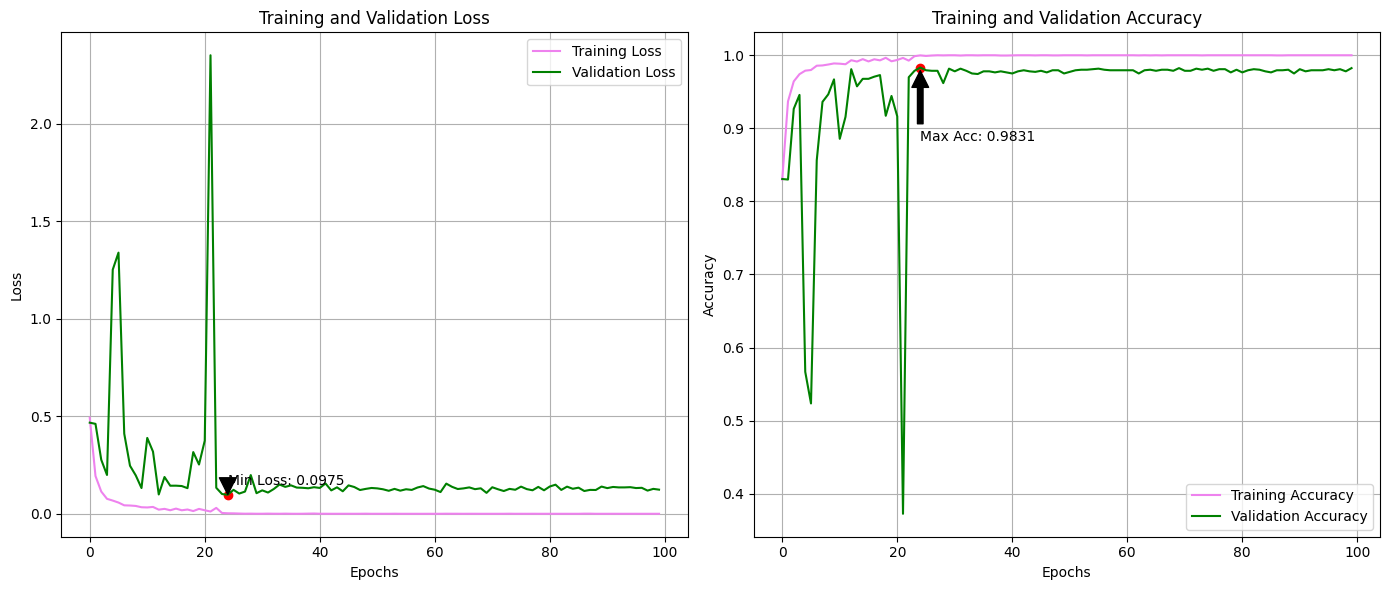

In [9]:
import matplotlib.pyplot as plt
import json

# Lire l'historique de l'entraînement à partir du fichier JSON
def read_jsonfile(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

# Charger l'historique
history = read_jsonfile('models/EfficientNetB1_history.json')

# Tracer les courbes de loss et d'accuracy pour l'entraînement et la validation
def plot_history(history):
    # Tracer la loss
    plt.figure(figsize=(14, 6))
    
    # Tracer la perte d'entraînement et de validation
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss', color='violet')
    plt.plot(history['val_loss'], label='Validation Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Annoter le minimum de la perte de validation
    min_val_loss = min(history['val_loss'])
    min_val_loss_epoch = history['val_loss'].index(min_val_loss)
    plt.scatter(min_val_loss_epoch, min_val_loss, color='red')
    plt.annotate(f'Min Loss: {min_val_loss:.4f}', xy=(min_val_loss_epoch, min_val_loss), 
                 xytext=(min_val_loss_epoch, min_val_loss + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    # Tracer la précision d'entraînement et de validation
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy', color='violet')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Annoter le maximum de la précision de validation
    max_val_acc = max(history['val_accuracy'])
    max_val_acc_epoch = history['val_accuracy'].index(max_val_acc)
    plt.scatter(max_val_acc_epoch, max_val_acc, color='red')
    plt.annotate(f'Max Acc: {max_val_acc:.4f}', xy=(max_val_acc_epoch, max_val_acc), 
                 xytext=(max_val_acc_epoch, max_val_acc - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()

# Afficher les courbes
plot_history(history)


# Tests

In [10]:
from tensorflow.keras.models import load_model
from src import inference, create_test_dataset
from sklearn import metrics

model = load_model("models/EfficientNetB1_ckpt_best_loss.keras")

df = pd.read_csv('data/processed/DL_test.csv')
X_test = df['image_path'].values
Y_test = df['category'].values
test_dataset = create_test_dataset(X_test, Y_test)

pred = model.predict(test_dataset)

54/54 [==============================] - 28s 324ms/step


In [11]:
print(metrics.classification_report(Y_test, pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       235
           1       0.97      0.99      0.98       243
           2       0.98      0.97      0.97       362
           3       1.00      0.98      0.99       305
           4       0.98      1.00      0.99       298
           5       0.98      0.99      0.98       261

    accuracy                           0.98      1704
   macro avg       0.98      0.99      0.98      1704
weighted avg       0.98      0.98      0.98      1704



# Simple Inference

In [12]:
pth = "./data/raw/data_04/a4_cni/image_0000003.jpg"
result = inference(model, pth)
result

1/1 [==============================] - 4s 4s/step


['national_identity_card']